In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

# Tắt các cảnh báo không quan trọng
warnings.filterwarnings('ignore')

# Cài đặt để Matplotlib hiển thị biểu đồ ngay trong notebook
%matplotlib inline

In [2]:
# --- Bước 1: Tải và Khám phá Dữ liệu ---
print("--- Bước 1: Tải và Khám phá Dữ liệu ---")
try:
    data = pd.read_csv('./data/animal.csv')
    print("Tải dữ liệu 'animal.csv' thành công!")
    
    print("\n5 dòng dữ liệu đầu tiên:")
    display(data.head())
    
    print("\nThông tin chung về dữ liệu:")
    data.info()
    
    print("\nKiểm tra giá trị thiếu (NaN):")
    print(data.isnull().sum())
    
except FileNotFoundError:
    print("Lỗi: Không tìm thấy tệp 'animal.csv'.")

--- Bước 1: Tải và Khám phá Dữ liệu ---
Tải dữ liệu 'animal.csv' thành công!

5 dòng dữ liệu đầu tiên:


,AnimalName,symptoms1,symptoms2,symptoms3,symptoms4,symptoms5,Dangerous
0,Dog,Fever,Diarrhea,Vomiting,Weight loss,Dehydration,Yes
1,Dog,Fever,Diarrhea,Coughing,Tiredness,Pains,Yes
2,Dog,Fever,Diarrhea,Coughing,Vomiting,Anorexia,Yes
3,Dog,Fever,Difficulty breathing,Coughing,Lethargy,Sneezing,Yes
4,Dog,Fever,Diarrhea,Coughing,Lethargy,Blue Eye,Yes



Thông tin chung về dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   AnimalName  871 non-null    object
 1   symptoms1   871 non-null    object
 2   symptoms2   871 non-null    object
 3   symptoms3   871 non-null    object
 4   symptoms4   871 non-null    object
 5   symptoms5   871 non-null    object
 6   Dangerous   869 non-null    object
dtypes: object(7)
memory usage: 47.8+ KB

Kiểm tra giá trị thiếu (NaN):
AnimalName    0
symptoms1     0
symptoms2     0
symptoms3     0
symptoms4     0
symptoms5     0
Dangerous     2
dtype: int64


In [3]:
# --- Bước 2: Tiền xử lý dữ liệu ---
# Đây là bước quan trọng nhất cho bộ dữ liệu "lạ" này

print("--- Bước 2: Bắt đầu Tiền xử lý dữ liệu ---")
data_processed = data.copy()

# 1. Xử lý giá trị thiếu (NaN)
# Cột 'Dangerous' thiếu 2 giá trị. Chúng ta sẽ xóa 2 dòng này.
data_processed = data_processed.dropna(subset=['Dangerous'])
print(f"Đã xóa {data.shape[0] - data_processed.shape[0]} dòng có giá trị 'Dangerous' bị thiếu.")

# 2. Làm sạch và chuẩn hóa văn bản
# Chuyển tất cả các cột về chữ thường (lowercase) để đồng nhất
# Ví dụ: 'Dog' và 'dog' sẽ thành 'dog'
for col in data_processed.columns:
    if data_processed[col].dtype == 'object':
        data_processed[col] = data_processed[col].str.lower().str.strip()

print("Đã chuyển tất cả dữ liệu chữ về dạng viết thường và bỏ dấu cách thừa.")

# 3. Mã hóa Biến mục tiêu (Target Encoding)
# Chuyển cột 'Dangerous' (Yes/No) thành số (1/0)
# Chúng ta sẽ dùng .map() cho đơn giản
data_processed['Dangerous'] = data_processed['Dangerous'].map({'yes': 1, 'no': 0})
print("Đã mã hóa cột 'Dangerous' (Yes -> 1, No -> 0).")

# 4. Mã hóa Biến đặc trưng (Feature Encoding)
# Chúng ta có 6 cột đặc trưng (AnimalName, symptoms1-5), tất cả đều là chữ.
# Chúng ta sẽ dùng One-Hot Encoding (pd.get_dummies) cho tất cả chúng.
# Thao tác này sẽ tạo ra RẤT NHIỀU cột mới.
feature_cols = ['AnimalName', 'symptoms1', 'symptoms2', 'symptoms3', 'symptoms4', 'symptoms5']
data_processed = pd.get_dummies(data_processed, columns=feature_cols)

print("Đã mã hóa One-Hot Encoding cho các cột đặc trưng.")
print("Dữ liệu sau khi xử lý (5 dòng đầu):")
display(data_processed.head())

print(f"\nTổng số cột sau khi mã hóa: {data_processed.shape[1]}")

--- Bước 2: Bắt đầu Tiền xử lý dữ liệu ---
Đã xóa 2 dòng có giá trị 'Dangerous' bị thiếu.
Đã chuyển tất cả dữ liệu chữ về dạng viết thường và bỏ dấu cách thừa.
Đã mã hóa cột 'Dangerous' (Yes -> 1, No -> 0).
Đã mã hóa One-Hot Encoding cho các cột đặc trưng.
Dữ liệu sau khi xử lý (5 dòng đầu):


,Dangerous,AnimalName_birds,AnimalName_black-tailed deer,AnimalName_buffaloes,AnimalName_cat,AnimalName_cattle,AnimalName_chicken,AnimalName_cow,AnimalName_deer,AnimalName_dog,...,symptoms5_vision problem,symptoms5_vomitting,symptoms5_wasting,symptoms5_weakness,symptoms5_week pulse,symptoms5_weight gain,symptoms5_weight loss,symptoms5_weightloss,symptoms5_weigth bearing long bones,symptoms5_wool production
0,1,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,1,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,1,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,1,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,1,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False



Tổng số cột sau khi mã hóa: 1112


In [4]:
# --- Bước 3: Chuẩn bị dữ liệu (Train/Test Split) ---
print("\n--- Bước 3: Chuẩn bị dữ liệu (Train/Test Split) ---")

# Tách X (đặc trưng) và y (mục tiêu)
# y là 'Dangerous', X là MỌI THỨ CÒN LẠI
X = data_processed.drop('Dangerous', axis=1)
y = data_processed['Dangerous']

# Chia dữ liệu (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Kích thước tập huấn luyện (X_train): {X_train.shape}")
print(f"Kích thước tập kiểm tra (X_test): {X_test.shape}")
print(f"Số lượng đặc trưng (features): {X_train.shape[1]}")


--- Bước 3: Chuẩn bị dữ liệu (Train/Test Split) ---
Kích thước tập huấn luyện (X_train): (695, 1111)
Kích thước tập kiểm tra (X_test): (174, 1111)
Số lượng đặc trưng (features): 1111


In [5]:
# --- Bước 4: Chuẩn hóa dữ liệu (Scaling) ---
# Bắt buộc cho SVM, đặc biệt khi các cột One-Hot (0/1) có thang đo khác nhau (dù ở đây là không)
print("\n--- Bước 4: Chuẩn hóa dữ liệu ---")

scaler = StandardScaler()

# Fit scaler CHỈ trên X_train
scaler.fit(X_train)

# Transform cả X_train và X_test
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Đã chuẩn hóa dữ liệu train và test.")


--- Bước 4: Chuẩn hóa dữ liệu ---
Đã chuẩn hóa dữ liệu train và test.


In [6]:
# --- Bước 5: Xây dựng và Tối ưu hóa SVM ---
import time
print("\n--- Bước 5: Xây dựng và Tối ưu hóa SVM ---")

start_time = time.time()

# 1. Định nghĩa các tham số để tìm kiếm
# Chúng ta dùng lưới tham số nhỏ vì dữ liệu có rất nhiều cột
param_grid = {
    'C': [0.1, 1, 10],            # Tham số C
    'kernel': ['linear', 'rbf']   # Thử 2 kernel phổ biến
}

# 2. Khởi tạo mô hình SVC
svc = SVC(random_state=42)

# 3. Khởi tạo GridSearchCV
grid_search_svm = GridSearchCV(estimator=svc, 
                               param_grid=param_grid, 
                               cv=3, 
                               scoring='accuracy', 
                               verbose=2, 
                               n_jobs=-1)

print("Bắt đầu huấn luyện GridSearchCV cho SVM (việc này có thể mất chút thời gian)...")
grid_search_svm.fit(X_train_scaled, y_train)

end_time = time.time()
print(f"--- Huấn luyện GridSearchCV hoàn tất sau {(end_time - start_time):.2f} giây ---")

# 4. In kết quả tốt nhất
print(f"\nTham số SVM tốt nhất tìm được: {grid_search_svm.best_params_}")
print(f"Độ chính xác tốt nhất trên tập huấn luyện (CV score): {grid_search_svm.best_score_:.4f}")


--- Bước 5: Xây dựng và Tối ưu hóa SVM ---
Bắt đầu huấn luyện GridSearchCV cho SVM (việc này có thể mất chút thời gian)...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
--- Huấn luyện GridSearchCV hoàn tất sau 8.87 giây ---

Tham số SVM tốt nhất tìm được: {'C': 0.1, 'kernel': 'linear'}
Độ chính xác tốt nhất trên tập huấn luyện (CV score): 0.9856



--- Bước 6: Đánh giá mô hình trên tập Test ---
Độ chính xác (Accuracy) của SVM tốt nhất trên tập Test: 1.0000

Báo cáo phân loại (Classification Report) của SVM:
                   precision    recall  f1-score   support

Not Dangerous (0)       1.00      1.00      1.00         4
    Dangerous (1)       1.00      1.00      1.00       170

         accuracy                           1.00       174
        macro avg       1.00      1.00      1.00       174
     weighted avg       1.00      1.00      1.00       174


Ma trận nhầm lẫn (Confusion Matrix):


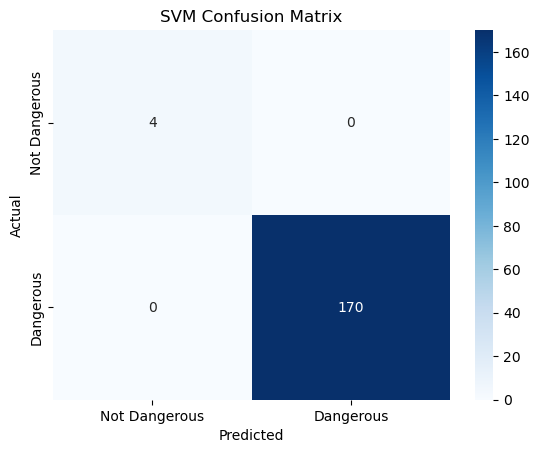

In [7]:
# --- Bước 6: Đánh giá mô hình SVM tốt nhất ---
print("\n--- Bước 6: Đánh giá mô hình trên tập Test ---")

# 1. Lấy mô hình tốt nhất
best_svm = grid_search_svm.best_estimator_

# 2. Dự đoán trên tập X_test ĐÃ ĐƯỢC CHUẨN HÓA
y_pred_svm = best_svm.predict(X_test_scaled)

# 3. Đánh giá
print(f"Độ chính xác (Accuracy) của SVM tốt nhất trên tập Test: {accuracy_score(y_test, y_pred_svm):.4f}")

print("\nBáo cáo phân loại (Classification Report) của SVM:")
# (Tương tự Hình 2.6 trong tài liệu)
print(classification_report(y_test, y_pred_svm, target_names=['Not Dangerous (0)', 'Dangerous (1)']))

print("\nMa trận nhầm lẫn (Confusion Matrix):")
# (Tương tự Hình 2.5 trong tài liệu)
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Dangerous', 'Dangerous'], 
            yticklabels=['Not Dangerous', 'Dangerous'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()